# Import

In [1]:
import os
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

In [2]:
df = pd.read_csv("data/bilan-electrique.csv")

In [3]:
df.head()

,Unnamed: 0,datasetid,recordid,record_timestamp,injection_rte,pertes,consommation_hta,soutirage_rte,production_profilee_photovoltaique,temperature_normale_lissee,...,consommation_profilee,production_profilee_aut,consommation_totale,mois,consommation_profilee_ent_hta,pseudo_rayonnement,soutirage_vers_autres_grd,horodate,consommation_telerelevee,production_photovoltaique
0,0,bilan-electrique-demi-heure,58084cf1db47bd052687d2808114953d19755216,2023-05-16T01:00:01.115Z,3.182218e+10,2.099434e+09,9.991167e+09,555480000.0,4304.0,14.3,...,1.851374e+10,1745767.0,3.177138e+10,5,9456817.0,57,290227009.0,2023-05-05T21:30:00+00:00,1.325764e+10,2060926.0
1,1,bilan-electrique-demi-heure,a0f3d1fa216f68beb1ba355e92718bb6582e7f88,2023-05-16T01:00:01.115Z,3.230077e+10,2.125454e+09,1.013050e+10,570125000.0,4608.0,14.3,...,1.866496e+10,1745767.0,3.219705e+10,5,9779855.0,57,288823000.0,2023-05-05T21:00:00+00:00,1.353209e+10,2153851.0
2,2,bilan-electrique-demi-heure,4abd9b6184d9c90f8ec85e3558fcac979e893297,2023-05-16T01:00:01.115Z,3.280950e+10,2.154360e+09,1.025865e+10,537333000.0,10363.0,14.4,...,1.884364e+10,1745767.0,3.264346e+10,5,10073269.0,56,282280700.0,2023-05-05T20:30:00+00:00,1.379982e+10,2176151.0
3,3,bilan-electrique-demi-heure,07382d88805d5a4ee9588fd6ff27c57af3630296,2023-05-16T01:00:01.115Z,3.122503e+10,2.003898e+09,1.036766e+10,477538000.0,10724.0,14.6,...,1.709235e+10,1745767.0,3.114739e+10,5,10514334.0,55,247365075.0,2023-05-05T20:00:00+00:00,1.405504e+10,2423144.0
4,4,bilan-electrique-demi-heure,ccf92afe83d1d3540f6cec6e79a574fd41992624,2023-05-16T01:00:01.115Z,3.107709e+10,1.987082e+09,1.038233e+10,452558000.0,7828.0,14.7,...,1.689479e+10,1745767.0,3.097478e+10,5,9587642.0,54,247766841.0,2023-05-05T19:30:00+00:00,1.407998e+10,2581626.0


## Create the model

The task is to predict a week (168 hours) of consumption. 2 approaches can be used with deep neural networks. We can either predict a single timestamp (next hour) with a given sequence and repeat the process with the predicted timestamp or directly predict the 168 hours from a given sequence with a sequence to sequence model. Predicting a single timestamp and then feeding the prediction back into the model for a week can be simpler in terms of model architecture, but it might lead to the propagation of errors. Since each prediction is used as input for the next prediction, errors can accumulate rapidly. This is especially true for long sequence predictions like a week (168 hours).On the other hand, directly predicting the next week's worth of data (sequence prediction) can potentially be more accurate since it can leverage information from all input at once. But the model architecture can be more complex, and the training might be more difficult and computationally expensive. Plus, it might overfit to specific sequences length and not generalize well to other lengths.

Here we have chosen to implement the simple model predicting only the next timestamp.

In [44]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

## Prepare the data

In [45]:
def create_sequences(data, sequence_length, pred_len=1):
    x = []
    y = []
    for i in range(len(data)-sequence_length-pred_len+1):
        x.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length:i+sequence_length+pred_len])
    return np.array(x), np.array(y)

In [46]:
from datetime import datetime
import time
from sklearn.model_selection import train_test_split

def preprocess_data(file_path, sequence_length=186, output_seq_len=1, split_ratio=0.8, batch_size=32):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    df['horodate'] = pd.to_datetime(df['horodate'])
    df = df.set_index('horodate')
    data = df['consommation_hta'].values.reshape(-1, 1)
    
    # Normalize the 'consommation_hta' data with MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data)
    
    x, y = create_sequences(data, sequence_length, output_seq_len)  # pass output_seq_len here
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-split_ratio, random_state=42)

    # Convert to Tensors and create data loaders
    train_data = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    test_data = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
    
    return train_loader, test_loader, scaler

## Train the model

In [78]:
import matplotlib.pyplot as plt
import tqdm

def train_model(model, train_loader, test_loader, num_epochs, learning_rate, patience=5):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss_list = []
    test_loss_list = []

    best_loss = float('inf')
    no_improve_epoch = 0

    for epoch in tqdm.tqdm(range(num_epochs), desc='Training the model', unit='epoch', total=num_epochs):
        
        train_loss = 0
        for inputs, targets in train_loader:
            output, hidden = model(inputs)
            loss = criterion(output, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)
            
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                output, hidden = model(inputs)
                loss = criterion(output, targets)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_loss_list.append(test_loss)

        print('Epoch [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, test_loss))

        # check for early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            no_improve_epoch = 0
        else:
            no_improve_epoch += 1
            if no_improve_epoch == patience:
                print('Early stopping')
                break

    # Plot training and testing loss
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(test_loss_list, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Time')
    plt.legend()
    plt.show()

    return model


Training the model:   0%|          | 0/1000 [00:00<?, ?epoch/s]/Users/charlesboydelatour/Library/Caches/pypoetry/virtualenvs/ei-ts-cs-uYASQlfq-py3.9/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 72, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/charlesboydelatour/Library/Caches/pypoetry/virtualenvs/ei-ts-cs-uYASQlfq-py3.9/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6, 1, 1])) that is different to the input size (torch.Size([6, 72, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/charlesboydelatour/Library/Caches/pypoetry/virtualenvs/ei-ts-cs-uYASQlfq-p

Epoch [1/1000], Loss: 0.2054, Test Loss: 0.1993


Training the model:   0%|          | 2/1000 [00:10<1:26:57,  5.23s/epoch]

Epoch [2/1000], Loss: 0.1959, Test Loss: 0.1870


Training the model:   0%|          | 3/1000 [00:15<1:27:28,  5.26s/epoch]

Epoch [3/1000], Loss: 0.1827, Test Loss: 0.1770


Training the model:   0%|          | 4/1000 [00:21<1:28:16,  5.32s/epoch]

Epoch [4/1000], Loss: 0.1780, Test Loss: 0.1729


Training the model:   0%|          | 5/1000 [00:26<1:30:10,  5.44s/epoch]

Epoch [5/1000], Loss: 0.1736, Test Loss: 0.1691


Training the model:   1%|          | 6/1000 [00:32<1:30:34,  5.47s/epoch]

Epoch [6/1000], Loss: 0.1705, Test Loss: 0.1644


Training the model:   1%|          | 7/1000 [00:37<1:31:22,  5.52s/epoch]

Epoch [7/1000], Loss: 0.1691, Test Loss: 0.1602


Training the model:   1%|          | 8/1000 [00:43<1:31:39,  5.54s/epoch]

Epoch [8/1000], Loss: 0.1693, Test Loss: 0.1353


Training the model:   1%|          | 9/1000 [00:50<1:38:37,  5.97s/epoch]

Epoch [9/1000], Loss: 0.1331, Test Loss: 0.1282


Training the model:   1%|          | 10/1000 [00:56<1:38:25,  5.96s/epoch]

Epoch [10/1000], Loss: 0.1270, Test Loss: 0.1260


Training the model:   1%|          | 11/1000 [01:01<1:35:01,  5.76s/epoch]

Epoch [11/1000], Loss: 0.1206, Test Loss: 0.1214


Training the model:   1%|          | 12/1000 [01:07<1:33:25,  5.67s/epoch]

Epoch [12/1000], Loss: 0.1163, Test Loss: 0.1147


Training the model:   1%|▏         | 13/1000 [01:12<1:31:34,  5.57s/epoch]

Epoch [13/1000], Loss: 0.1119, Test Loss: 0.1110


Training the model:   1%|▏         | 14/1000 [01:17<1:30:25,  5.50s/epoch]

Epoch [14/1000], Loss: 0.1083, Test Loss: 0.1076


Training the model:   2%|▏         | 15/1000 [01:23<1:29:31,  5.45s/epoch]

Epoch [15/1000], Loss: 0.1060, Test Loss: 0.1049


Training the model:   2%|▏         | 16/1000 [01:28<1:28:52,  5.42s/epoch]

Epoch [16/1000], Loss: 0.1039, Test Loss: 0.1024


Training the model:   2%|▏         | 17/1000 [01:33<1:28:03,  5.38s/epoch]

Epoch [17/1000], Loss: 0.1021, Test Loss: 0.1007


Training the model:   2%|▏         | 18/1000 [01:39<1:27:41,  5.36s/epoch]

Epoch [18/1000], Loss: 0.1003, Test Loss: 0.0999


Training the model:   2%|▏         | 19/1000 [01:44<1:27:28,  5.35s/epoch]

Epoch [19/1000], Loss: 0.0984, Test Loss: 0.0989


Training the model:   2%|▏         | 20/1000 [01:49<1:27:19,  5.35s/epoch]

Epoch [20/1000], Loss: 0.0965, Test Loss: 0.0974


Training the model:   2%|▏         | 21/1000 [01:55<1:26:56,  5.33s/epoch]

Epoch [21/1000], Loss: 0.0949, Test Loss: 0.0957


Training the model:   2%|▏         | 22/1000 [02:00<1:26:46,  5.32s/epoch]

Epoch [22/1000], Loss: 0.0936, Test Loss: 0.0944


Training the model:   2%|▏         | 23/1000 [02:05<1:26:43,  5.33s/epoch]

Epoch [23/1000], Loss: 0.0926, Test Loss: 0.0934


Training the model:   2%|▏         | 24/1000 [02:11<1:28:01,  5.41s/epoch]

Epoch [24/1000], Loss: 0.0918, Test Loss: 0.0927


Training the model:   2%|▎         | 25/1000 [02:16<1:28:18,  5.43s/epoch]

Epoch [25/1000], Loss: 0.0912, Test Loss: 0.0921


Training the model:   3%|▎         | 26/1000 [02:22<1:27:44,  5.40s/epoch]

Epoch [26/1000], Loss: 0.0906, Test Loss: 0.0916


Training the model:   3%|▎         | 27/1000 [02:27<1:27:44,  5.41s/epoch]

Epoch [27/1000], Loss: 0.0900, Test Loss: 0.0912


Training the model:   3%|▎         | 28/1000 [02:32<1:27:12,  5.38s/epoch]

Epoch [28/1000], Loss: 0.0895, Test Loss: 0.0907


Training the model:   3%|▎         | 29/1000 [02:38<1:27:13,  5.39s/epoch]

Epoch [29/1000], Loss: 0.0890, Test Loss: 0.0903


Training the model:   3%|▎         | 30/1000 [02:43<1:27:09,  5.39s/epoch]

Epoch [30/1000], Loss: 0.0884, Test Loss: 0.0897


Training the model:   3%|▎         | 31/1000 [02:49<1:27:05,  5.39s/epoch]

Epoch [31/1000], Loss: 0.0879, Test Loss: 0.0891


Training the model:   3%|▎         | 32/1000 [02:54<1:27:11,  5.40s/epoch]

Epoch [32/1000], Loss: 0.0873, Test Loss: 0.0886


Training the model:   3%|▎         | 33/1000 [02:59<1:26:49,  5.39s/epoch]

Epoch [33/1000], Loss: 0.0868, Test Loss: 0.0881


Training the model:   3%|▎         | 34/1000 [03:05<1:26:39,  5.38s/epoch]

Epoch [34/1000], Loss: 0.0863, Test Loss: 0.0876


Training the model:   4%|▎         | 35/1000 [03:10<1:26:59,  5.41s/epoch]

Epoch [35/1000], Loss: 0.0857, Test Loss: 0.0871


Training the model:   4%|▎         | 36/1000 [03:16<1:27:34,  5.45s/epoch]

Epoch [36/1000], Loss: 0.0852, Test Loss: 0.0865


Training the model:   4%|▎         | 37/1000 [03:21<1:28:16,  5.50s/epoch]

Epoch [37/1000], Loss: 0.0846, Test Loss: 0.0859


Training the model:   4%|▍         | 38/1000 [03:27<1:28:10,  5.50s/epoch]

Epoch [38/1000], Loss: 0.0841, Test Loss: 0.0852


Training the model:   4%|▍         | 39/1000 [03:32<1:28:28,  5.52s/epoch]

Epoch [39/1000], Loss: 0.0836, Test Loss: 0.0847


Training the model:   4%|▍         | 40/1000 [03:38<1:28:36,  5.54s/epoch]

Epoch [40/1000], Loss: 0.0831, Test Loss: 0.0844


Training the model:   4%|▍         | 41/1000 [03:43<1:27:32,  5.48s/epoch]

Epoch [41/1000], Loss: 0.0826, Test Loss: 0.0842


Training the model:   4%|▍         | 42/1000 [03:49<1:27:16,  5.47s/epoch]

Epoch [42/1000], Loss: 0.0821, Test Loss: 0.0839


Training the model:   4%|▍         | 43/1000 [03:54<1:27:25,  5.48s/epoch]

Epoch [43/1000], Loss: 0.0816, Test Loss: 0.0835


Training the model:   4%|▍         | 44/1000 [04:00<1:27:30,  5.49s/epoch]

Epoch [44/1000], Loss: 0.0810, Test Loss: 0.0830


Training the model:   4%|▍         | 45/1000 [04:05<1:27:36,  5.50s/epoch]

Epoch [45/1000], Loss: 0.0804, Test Loss: 0.0826


Training the model:   5%|▍         | 46/1000 [04:11<1:27:42,  5.52s/epoch]

Epoch [46/1000], Loss: 0.0800, Test Loss: 0.0823


Training the model:   5%|▍         | 47/1000 [04:16<1:27:38,  5.52s/epoch]

Epoch [47/1000], Loss: 0.0795, Test Loss: 0.0817


Training the model:   5%|▍         | 48/1000 [04:22<1:27:27,  5.51s/epoch]

Epoch [48/1000], Loss: 0.0790, Test Loss: 0.0812


Training the model:   5%|▍         | 49/1000 [04:27<1:26:46,  5.47s/epoch]

Epoch [49/1000], Loss: 0.0785, Test Loss: 0.0807


Training the model:   5%|▌         | 50/1000 [04:33<1:27:12,  5.51s/epoch]

Epoch [50/1000], Loss: 0.0781, Test Loss: 0.0803


Training the model:   5%|▌         | 51/1000 [04:38<1:27:01,  5.50s/epoch]

Epoch [51/1000], Loss: 0.0777, Test Loss: 0.0801


Training the model:   5%|▌         | 52/1000 [04:44<1:26:44,  5.49s/epoch]

Epoch [52/1000], Loss: 0.0772, Test Loss: 0.0799


Training the model:   5%|▌         | 53/1000 [04:49<1:26:16,  5.47s/epoch]

Epoch [53/1000], Loss: 0.0768, Test Loss: 0.0795


Training the model:   5%|▌         | 54/1000 [04:55<1:25:41,  5.44s/epoch]

Epoch [54/1000], Loss: 0.0764, Test Loss: 0.0793


Training the model:   6%|▌         | 55/1000 [05:00<1:25:33,  5.43s/epoch]

Epoch [55/1000], Loss: 0.0761, Test Loss: 0.0789


Training the model:   6%|▌         | 56/1000 [05:05<1:25:20,  5.42s/epoch]

Epoch [56/1000], Loss: 0.0757, Test Loss: 0.0786


Training the model:   6%|▌         | 57/1000 [05:11<1:25:05,  5.41s/epoch]

Epoch [57/1000], Loss: 0.0754, Test Loss: 0.0783


Training the model:   6%|▌         | 58/1000 [05:16<1:25:16,  5.43s/epoch]

Epoch [58/1000], Loss: 0.0752, Test Loss: 0.0779


Training the model:   6%|▌         | 59/1000 [05:22<1:27:53,  5.60s/epoch]

Epoch [59/1000], Loss: 0.0749, Test Loss: 0.0775


Training the model:   6%|▌         | 60/1000 [05:28<1:27:48,  5.60s/epoch]

Epoch [60/1000], Loss: 0.0746, Test Loss: 0.0771


Training the model:   6%|▌         | 61/1000 [05:33<1:27:11,  5.57s/epoch]

Epoch [61/1000], Loss: 0.0743, Test Loss: 0.0767


Training the model:   6%|▌         | 62/1000 [05:39<1:27:22,  5.59s/epoch]

Epoch [62/1000], Loss: 0.0740, Test Loss: 0.0764


Training the model:   6%|▋         | 63/1000 [05:45<1:27:08,  5.58s/epoch]

Epoch [63/1000], Loss: 0.0737, Test Loss: 0.0761


Training the model:   6%|▋         | 64/1000 [05:50<1:27:03,  5.58s/epoch]

Epoch [64/1000], Loss: 0.0734, Test Loss: 0.0758


Training the model:   6%|▋         | 65/1000 [05:56<1:27:05,  5.59s/epoch]

Epoch [65/1000], Loss: 0.0732, Test Loss: 0.0755


Training the model:   7%|▋         | 66/1000 [06:01<1:26:37,  5.56s/epoch]

Epoch [66/1000], Loss: 0.0729, Test Loss: 0.0752


Training the model:   7%|▋         | 67/1000 [06:07<1:26:02,  5.53s/epoch]

Epoch [67/1000], Loss: 0.0726, Test Loss: 0.0749


Training the model:   7%|▋         | 68/1000 [06:12<1:25:39,  5.51s/epoch]

Epoch [68/1000], Loss: 0.0724, Test Loss: 0.0747


Training the model:   7%|▋         | 69/1000 [06:18<1:25:25,  5.51s/epoch]

Epoch [69/1000], Loss: 0.0721, Test Loss: 0.0744


Training the model:   7%|▋         | 70/1000 [06:23<1:25:23,  5.51s/epoch]

Epoch [70/1000], Loss: 0.0719, Test Loss: 0.0742


Training the model:   7%|▋         | 71/1000 [06:29<1:25:05,  5.50s/epoch]

Epoch [71/1000], Loss: 0.0716, Test Loss: 0.0739


Training the model:   7%|▋         | 72/1000 [06:34<1:25:09,  5.51s/epoch]

Epoch [72/1000], Loss: 0.0714, Test Loss: 0.0737


Training the model:   7%|▋         | 73/1000 [06:40<1:24:56,  5.50s/epoch]

Epoch [73/1000], Loss: 0.0712, Test Loss: 0.0735


Training the model:   7%|▋         | 74/1000 [06:45<1:24:53,  5.50s/epoch]

Epoch [74/1000], Loss: 0.0709, Test Loss: 0.0733


Training the model:   8%|▊         | 75/1000 [06:51<1:24:43,  5.50s/epoch]

Epoch [75/1000], Loss: 0.0707, Test Loss: 0.0730


Training the model:   8%|▊         | 76/1000 [06:56<1:24:44,  5.50s/epoch]

Epoch [76/1000], Loss: 0.0705, Test Loss: 0.0728


Training the model:   8%|▊         | 77/1000 [07:02<1:24:21,  5.48s/epoch]

Epoch [77/1000], Loss: 0.0703, Test Loss: 0.0726


Training the model:   8%|▊         | 78/1000 [07:07<1:24:22,  5.49s/epoch]

Epoch [78/1000], Loss: 0.0701, Test Loss: 0.0724


Training the model:   8%|▊         | 79/1000 [07:13<1:24:08,  5.48s/epoch]

Epoch [79/1000], Loss: 0.0699, Test Loss: 0.0722


Training the model:   8%|▊         | 80/1000 [07:18<1:24:01,  5.48s/epoch]

Epoch [80/1000], Loss: 0.0697, Test Loss: 0.0720


Training the model:   8%|▊         | 81/1000 [07:24<1:24:31,  5.52s/epoch]

Epoch [81/1000], Loss: 0.0695, Test Loss: 0.0718


Training the model:   8%|▊         | 82/1000 [07:29<1:24:05,  5.50s/epoch]

Epoch [82/1000], Loss: 0.0693, Test Loss: 0.0716


Training the model:   8%|▊         | 83/1000 [07:35<1:23:50,  5.49s/epoch]

Epoch [83/1000], Loss: 0.0691, Test Loss: 0.0714


Training the model:   8%|▊         | 84/1000 [07:40<1:23:39,  5.48s/epoch]

Epoch [84/1000], Loss: 0.0689, Test Loss: 0.0712


Training the model:   8%|▊         | 85/1000 [07:46<1:23:35,  5.48s/epoch]

Epoch [85/1000], Loss: 0.0688, Test Loss: 0.0710


Training the model:   9%|▊         | 86/1000 [07:51<1:25:10,  5.59s/epoch]

Epoch [86/1000], Loss: 0.0686, Test Loss: 0.0708


Training the model:   9%|▊         | 87/1000 [07:57<1:25:40,  5.63s/epoch]

Epoch [87/1000], Loss: 0.0684, Test Loss: 0.0706


Training the model:   9%|▉         | 88/1000 [08:03<1:25:51,  5.65s/epoch]

Epoch [88/1000], Loss: 0.0682, Test Loss: 0.0705


Training the model:   9%|▉         | 89/1000 [08:08<1:24:48,  5.59s/epoch]

Epoch [89/1000], Loss: 0.0681, Test Loss: 0.0703


Training the model:   9%|▉         | 90/1000 [08:14<1:23:50,  5.53s/epoch]

Epoch [90/1000], Loss: 0.0679, Test Loss: 0.0701


Training the model:   9%|▉         | 91/1000 [08:19<1:23:10,  5.49s/epoch]

Epoch [91/1000], Loss: 0.0677, Test Loss: 0.0700


Training the model:   9%|▉         | 92/1000 [08:25<1:23:07,  5.49s/epoch]

Epoch [92/1000], Loss: 0.0676, Test Loss: 0.0699


Training the model:   9%|▉         | 93/1000 [08:30<1:22:35,  5.46s/epoch]

Epoch [93/1000], Loss: 0.0674, Test Loss: 0.0697


Training the model:   9%|▉         | 94/1000 [08:35<1:22:11,  5.44s/epoch]

Epoch [94/1000], Loss: 0.0673, Test Loss: 0.0696


Training the model:  10%|▉         | 95/1000 [08:41<1:21:48,  5.42s/epoch]

Epoch [95/1000], Loss: 0.0672, Test Loss: 0.0694


Training the model:  10%|▉         | 96/1000 [08:46<1:21:33,  5.41s/epoch]

Epoch [96/1000], Loss: 0.0670, Test Loss: 0.0693


Training the model:  10%|▉         | 97/1000 [08:52<1:21:29,  5.42s/epoch]

Epoch [97/1000], Loss: 0.0669, Test Loss: 0.0692


Training the model:  10%|▉         | 98/1000 [08:57<1:21:23,  5.41s/epoch]

Epoch [98/1000], Loss: 0.0667, Test Loss: 0.0691


Training the model:  10%|▉         | 99/1000 [09:02<1:21:11,  5.41s/epoch]

Epoch [99/1000], Loss: 0.0666, Test Loss: 0.0690


Training the model:  10%|█         | 100/1000 [09:08<1:21:08,  5.41s/epoch]

Epoch [100/1000], Loss: 0.0665, Test Loss: 0.0688


Training the model:  10%|█         | 101/1000 [09:13<1:21:08,  5.42s/epoch]

Epoch [101/1000], Loss: 0.0663, Test Loss: 0.0687


Training the model:  10%|█         | 102/1000 [09:19<1:20:57,  5.41s/epoch]

Epoch [102/1000], Loss: 0.0662, Test Loss: 0.0686


Training the model:  10%|█         | 103/1000 [09:24<1:20:48,  5.40s/epoch]

Epoch [103/1000], Loss: 0.0661, Test Loss: 0.0685


Training the model:  10%|█         | 104/1000 [09:29<1:20:39,  5.40s/epoch]

Epoch [104/1000], Loss: 0.0659, Test Loss: 0.0685


Training the model:  10%|█         | 105/1000 [09:35<1:20:37,  5.40s/epoch]

Epoch [105/1000], Loss: 0.0658, Test Loss: 0.0684


Training the model:  11%|█         | 106/1000 [09:40<1:20:25,  5.40s/epoch]

Epoch [106/1000], Loss: 0.0657, Test Loss: 0.0683


Training the model:  11%|█         | 107/1000 [09:46<1:20:14,  5.39s/epoch]

Epoch [107/1000], Loss: 0.0656, Test Loss: 0.0682


Training the model:  11%|█         | 108/1000 [09:51<1:20:06,  5.39s/epoch]

Epoch [108/1000], Loss: 0.0654, Test Loss: 0.0681


Training the model:  11%|█         | 109/1000 [09:57<1:20:48,  5.44s/epoch]

Epoch [109/1000], Loss: 0.0653, Test Loss: 0.0680


Training the model:  11%|█         | 110/1000 [10:02<1:20:28,  5.43s/epoch]

Epoch [110/1000], Loss: 0.0652, Test Loss: 0.0680


Training the model:  11%|█         | 111/1000 [10:07<1:20:16,  5.42s/epoch]

Epoch [111/1000], Loss: 0.0651, Test Loss: 0.0679


Training the model:  11%|█         | 112/1000 [10:13<1:20:23,  5.43s/epoch]

Epoch [112/1000], Loss: 0.0650, Test Loss: 0.0678


Training the model:  11%|█▏        | 113/1000 [10:18<1:21:39,  5.52s/epoch]

Epoch [113/1000], Loss: 0.0649, Test Loss: 0.0677


Training the model:  11%|█▏        | 114/1000 [10:24<1:21:39,  5.53s/epoch]

Epoch [114/1000], Loss: 0.0648, Test Loss: 0.0676


Training the model:  12%|█▏        | 115/1000 [10:30<1:21:52,  5.55s/epoch]

Epoch [115/1000], Loss: 0.0647, Test Loss: 0.0675


Training the model:  12%|█▏        | 116/1000 [10:35<1:21:27,  5.53s/epoch]

Epoch [116/1000], Loss: 0.0646, Test Loss: 0.0674


Training the model:  12%|█▏        | 117/1000 [10:41<1:21:28,  5.54s/epoch]

Epoch [117/1000], Loss: 0.0645, Test Loss: 0.0674


Training the model:  12%|█▏        | 118/1000 [10:46<1:20:44,  5.49s/epoch]

Epoch [118/1000], Loss: 0.0644, Test Loss: 0.0673


Training the model:  12%|█▏        | 119/1000 [10:51<1:20:18,  5.47s/epoch]

Epoch [119/1000], Loss: 0.0643, Test Loss: 0.0672


Training the model:  12%|█▏        | 120/1000 [10:57<1:20:03,  5.46s/epoch]

Epoch [120/1000], Loss: 0.0642, Test Loss: 0.0672


Training the model:  12%|█▏        | 121/1000 [11:02<1:19:50,  5.45s/epoch]

Epoch [121/1000], Loss: 0.0641, Test Loss: 0.0671


Training the model:  12%|█▏        | 122/1000 [11:08<1:20:01,  5.47s/epoch]

Epoch [122/1000], Loss: 0.0640, Test Loss: 0.0671


Training the model:  12%|█▏        | 123/1000 [11:13<1:20:17,  5.49s/epoch]

Epoch [123/1000], Loss: 0.0639, Test Loss: 0.0670


Training the model:  12%|█▏        | 124/1000 [11:19<1:20:41,  5.53s/epoch]

Epoch [124/1000], Loss: 0.0638, Test Loss: 0.0669


Training the model:  12%|█▎        | 125/1000 [11:25<1:20:43,  5.54s/epoch]

Epoch [125/1000], Loss: 0.0637, Test Loss: 0.0668


Training the model:  13%|█▎        | 126/1000 [11:30<1:20:32,  5.53s/epoch]

Epoch [126/1000], Loss: 0.0636, Test Loss: 0.0667


Training the model:  13%|█▎        | 127/1000 [11:36<1:20:55,  5.56s/epoch]

Epoch [127/1000], Loss: 0.0635, Test Loss: 0.0666


Training the model:  13%|█▎        | 128/1000 [11:41<1:20:40,  5.55s/epoch]

Epoch [128/1000], Loss: 0.0634, Test Loss: 0.0665


Training the model:  13%|█▎        | 129/1000 [11:47<1:21:05,  5.59s/epoch]

Epoch [129/1000], Loss: 0.0634, Test Loss: 0.0664


Training the model:  13%|█▎        | 130/1000 [11:53<1:21:12,  5.60s/epoch]

Epoch [130/1000], Loss: 0.0633, Test Loss: 0.0663


Training the model:  13%|█▎        | 131/1000 [11:58<1:20:41,  5.57s/epoch]

Epoch [131/1000], Loss: 0.0632, Test Loss: 0.0662


Training the model:  13%|█▎        | 132/1000 [12:04<1:20:34,  5.57s/epoch]

Epoch [132/1000], Loss: 0.0631, Test Loss: 0.0661


Training the model:  13%|█▎        | 133/1000 [12:09<1:20:27,  5.57s/epoch]

Epoch [133/1000], Loss: 0.0630, Test Loss: 0.0660


Training the model:  13%|█▎        | 134/1000 [12:15<1:20:07,  5.55s/epoch]

Epoch [134/1000], Loss: 0.0629, Test Loss: 0.0659


Training the model:  14%|█▎        | 135/1000 [12:20<1:19:54,  5.54s/epoch]

Epoch [135/1000], Loss: 0.0629, Test Loss: 0.0658


Training the model:  14%|█▎        | 136/1000 [12:26<1:19:50,  5.54s/epoch]

Epoch [136/1000], Loss: 0.0628, Test Loss: 0.0657


Training the model:  14%|█▎        | 137/1000 [12:31<1:20:05,  5.57s/epoch]

Epoch [137/1000], Loss: 0.0627, Test Loss: 0.0656


Training the model:  14%|█▍        | 138/1000 [12:37<1:20:10,  5.58s/epoch]

Epoch [138/1000], Loss: 0.0626, Test Loss: 0.0655


Training the model:  14%|█▍        | 139/1000 [12:43<1:19:51,  5.56s/epoch]

Epoch [139/1000], Loss: 0.0625, Test Loss: 0.0654


Training the model:  14%|█▍        | 140/1000 [12:48<1:19:44,  5.56s/epoch]

Epoch [140/1000], Loss: 0.0624, Test Loss: 0.0653


Training the model:  14%|█▍        | 141/1000 [12:54<1:19:05,  5.52s/epoch]

Epoch [141/1000], Loss: 0.0623, Test Loss: 0.0652


Training the model:  14%|█▍        | 142/1000 [12:59<1:18:47,  5.51s/epoch]

Epoch [142/1000], Loss: 0.0622, Test Loss: 0.0653


Training the model:  14%|█▍        | 143/1000 [13:04<1:18:13,  5.48s/epoch]

Epoch [143/1000], Loss: 0.0621, Test Loss: 0.0652


Training the model:  14%|█▍        | 144/1000 [13:10<1:17:55,  5.46s/epoch]

Epoch [144/1000], Loss: 0.0620, Test Loss: 0.0651


Training the model:  14%|█▍        | 145/1000 [13:15<1:17:35,  5.45s/epoch]

Epoch [145/1000], Loss: 0.0620, Test Loss: 0.0650


Training the model:  15%|█▍        | 146/1000 [13:21<1:17:16,  5.43s/epoch]

Epoch [146/1000], Loss: 0.0619, Test Loss: 0.0650


Training the model:  15%|█▍        | 147/1000 [13:26<1:17:03,  5.42s/epoch]

Epoch [147/1000], Loss: 0.0618, Test Loss: 0.0649


Training the model:  15%|█▍        | 148/1000 [13:31<1:17:00,  5.42s/epoch]

Epoch [148/1000], Loss: 0.0618, Test Loss: 0.0649


Training the model:  15%|█▍        | 149/1000 [13:37<1:16:46,  5.41s/epoch]

Epoch [149/1000], Loss: 0.0617, Test Loss: 0.0648


Training the model:  15%|█▌        | 150/1000 [13:42<1:16:35,  5.41s/epoch]

Epoch [150/1000], Loss: 0.0616, Test Loss: 0.0646


Training the model:  15%|█▌        | 151/1000 [13:48<1:16:30,  5.41s/epoch]

Epoch [151/1000], Loss: 0.0615, Test Loss: 0.0646


Training the model:  15%|█▌        | 152/1000 [13:53<1:17:07,  5.46s/epoch]

Epoch [152/1000], Loss: 0.0614, Test Loss: 0.0645


Training the model:  15%|█▌        | 153/1000 [13:59<1:17:37,  5.50s/epoch]

Epoch [153/1000], Loss: 0.0614, Test Loss: 0.0644


Training the model:  15%|█▌        | 154/1000 [14:04<1:18:14,  5.55s/epoch]

Epoch [154/1000], Loss: 0.0613, Test Loss: 0.0644


Training the model:  16%|█▌        | 155/1000 [14:10<1:18:23,  5.57s/epoch]

Epoch [155/1000], Loss: 0.0612, Test Loss: 0.0643


Training the model:  16%|█▌        | 156/1000 [14:16<1:18:04,  5.55s/epoch]

Epoch [156/1000], Loss: 0.0612, Test Loss: 0.0643


Training the model:  16%|█▌        | 157/1000 [14:21<1:17:36,  5.52s/epoch]

Epoch [157/1000], Loss: 0.0611, Test Loss: 0.0642


Training the model:  16%|█▌        | 158/1000 [14:27<1:18:09,  5.57s/epoch]

Epoch [158/1000], Loss: 0.0610, Test Loss: 0.0642


Training the model:  16%|█▌        | 159/1000 [14:33<1:19:04,  5.64s/epoch]

Epoch [159/1000], Loss: 0.0609, Test Loss: 0.0642


Training the model:  16%|█▌        | 160/1000 [14:38<1:17:58,  5.57s/epoch]

Epoch [160/1000], Loss: 0.0609, Test Loss: 0.0641


Training the model:  16%|█▌        | 161/1000 [14:44<1:18:12,  5.59s/epoch]

Epoch [161/1000], Loss: 0.0608, Test Loss: 0.0641


Training the model:  16%|█▌        | 162/1000 [14:49<1:18:02,  5.59s/epoch]

Epoch [162/1000], Loss: 0.0607, Test Loss: 0.0641


Training the model:  16%|█▋        | 163/1000 [14:55<1:17:48,  5.58s/epoch]

Epoch [163/1000], Loss: 0.0607, Test Loss: 0.0641


Training the model:  16%|█▋        | 164/1000 [15:00<1:17:31,  5.56s/epoch]

Epoch [164/1000], Loss: 0.0606, Test Loss: 0.0641


Training the model:  16%|█▋        | 165/1000 [15:06<1:17:37,  5.58s/epoch]

Epoch [165/1000], Loss: 0.0605, Test Loss: 0.0639


Training the model:  17%|█▋        | 166/1000 [15:11<1:17:07,  5.55s/epoch]

Epoch [166/1000], Loss: 0.0605, Test Loss: 0.0639


Training the model:  17%|█▋        | 167/1000 [15:17<1:17:25,  5.58s/epoch]

Epoch [167/1000], Loss: 0.0604, Test Loss: 0.0639


Training the model:  17%|█▋        | 168/1000 [15:22<1:17:01,  5.55s/epoch]

Epoch [168/1000], Loss: 0.0604, Test Loss: 0.0639


Training the model:  17%|█▋        | 169/1000 [15:28<1:16:33,  5.53s/epoch]

Epoch [169/1000], Loss: 0.0603, Test Loss: 0.0638


Training the model:  17%|█▋        | 170/1000 [15:33<1:16:20,  5.52s/epoch]

Epoch [170/1000], Loss: 0.0602, Test Loss: 0.0637


Training the model:  17%|█▋        | 171/1000 [15:39<1:16:07,  5.51s/epoch]

Epoch [171/1000], Loss: 0.0602, Test Loss: 0.0637


Training the model:  17%|█▋        | 172/1000 [15:44<1:15:39,  5.48s/epoch]

Epoch [172/1000], Loss: 0.0601, Test Loss: 0.0637


Training the model:  17%|█▋        | 173/1000 [15:50<1:16:16,  5.53s/epoch]

Epoch [173/1000], Loss: 0.0601, Test Loss: 0.0636


Training the model:  17%|█▋        | 174/1000 [15:56<1:16:06,  5.53s/epoch]

Epoch [174/1000], Loss: 0.0600, Test Loss: 0.0636


Training the model:  18%|█▊        | 175/1000 [16:01<1:15:48,  5.51s/epoch]

Epoch [175/1000], Loss: 0.0600, Test Loss: 0.0636


Training the model:  18%|█▊        | 176/1000 [16:06<1:15:19,  5.48s/epoch]

Epoch [176/1000], Loss: 0.0599, Test Loss: 0.0635


Training the model:  18%|█▊        | 177/1000 [16:12<1:15:01,  5.47s/epoch]

Epoch [177/1000], Loss: 0.0599, Test Loss: 0.0635


Training the model:  18%|█▊        | 178/1000 [16:17<1:14:36,  5.45s/epoch]

Epoch [178/1000], Loss: 0.0598, Test Loss: 0.0635


Training the model:  18%|█▊        | 179/1000 [16:23<1:14:15,  5.43s/epoch]

Epoch [179/1000], Loss: 0.0598, Test Loss: 0.0635


Training the model:  18%|█▊        | 180/1000 [16:28<1:14:10,  5.43s/epoch]

Epoch [180/1000], Loss: 0.0597, Test Loss: 0.0634


Training the model:  18%|█▊        | 181/1000 [16:34<1:14:56,  5.49s/epoch]

Epoch [181/1000], Loss: 0.0596, Test Loss: 0.0634


Training the model:  18%|█▊        | 182/1000 [16:39<1:14:43,  5.48s/epoch]

Epoch [182/1000], Loss: 0.0596, Test Loss: 0.0633


Training the model:  18%|█▊        | 183/1000 [16:45<1:15:00,  5.51s/epoch]

Epoch [183/1000], Loss: 0.0595, Test Loss: 0.0633


Training the model:  18%|█▊        | 184/1000 [16:50<1:15:03,  5.52s/epoch]

Epoch [184/1000], Loss: 0.0595, Test Loss: 0.0632


Training the model:  18%|█▊        | 185/1000 [16:56<1:14:52,  5.51s/epoch]

Epoch [185/1000], Loss: 0.0594, Test Loss: 0.0632


Training the model:  19%|█▊        | 186/1000 [17:01<1:15:05,  5.53s/epoch]

Epoch [186/1000], Loss: 0.0594, Test Loss: 0.0632


Training the model:  19%|█▊        | 187/1000 [17:07<1:16:22,  5.64s/epoch]

Epoch [187/1000], Loss: 0.0593, Test Loss: 0.0632


Training the model:  19%|█▉        | 188/1000 [17:13<1:16:09,  5.63s/epoch]

Epoch [188/1000], Loss: 0.0593, Test Loss: 0.0632


Training the model:  19%|█▉        | 189/1000 [17:18<1:15:38,  5.60s/epoch]

Epoch [189/1000], Loss: 0.0592, Test Loss: 0.0632


Training the model:  19%|█▉        | 190/1000 [17:24<1:14:46,  5.54s/epoch]

Epoch [190/1000], Loss: 0.0592, Test Loss: 0.0632


Training the model:  19%|█▉        | 191/1000 [17:29<1:14:21,  5.51s/epoch]

Epoch [191/1000], Loss: 0.0591, Test Loss: 0.0632


Training the model:  19%|█▉        | 192/1000 [17:35<1:13:48,  5.48s/epoch]

Epoch [192/1000], Loss: 0.0591, Test Loss: 0.0631


Training the model:  19%|█▉        | 193/1000 [17:40<1:13:23,  5.46s/epoch]

Epoch [193/1000], Loss: 0.0590, Test Loss: 0.0631


Training the model:  19%|█▉        | 194/1000 [17:45<1:13:08,  5.44s/epoch]

Epoch [194/1000], Loss: 0.0590, Test Loss: 0.0631


Training the model:  20%|█▉        | 195/1000 [17:51<1:12:53,  5.43s/epoch]

Epoch [195/1000], Loss: 0.0589, Test Loss: 0.0631


Training the model:  20%|█▉        | 196/1000 [17:56<1:13:07,  5.46s/epoch]

Epoch [196/1000], Loss: 0.0588, Test Loss: 0.0630


Training the model:  20%|█▉        | 197/1000 [18:02<1:13:26,  5.49s/epoch]

Epoch [197/1000], Loss: 0.0588, Test Loss: 0.0630


Training the model:  20%|█▉        | 198/1000 [18:07<1:13:15,  5.48s/epoch]

Epoch [198/1000], Loss: 0.0587, Test Loss: 0.0630


Training the model:  20%|█▉        | 199/1000 [18:13<1:13:10,  5.48s/epoch]

Epoch [199/1000], Loss: 0.0587, Test Loss: 0.0629


Training the model:  20%|██        | 200/1000 [18:18<1:12:49,  5.46s/epoch]

Epoch [200/1000], Loss: 0.0587, Test Loss: 0.0629


Training the model:  20%|██        | 201/1000 [18:24<1:13:11,  5.50s/epoch]

Epoch [201/1000], Loss: 0.0586, Test Loss: 0.0629


Training the model:  20%|██        | 202/1000 [18:29<1:13:10,  5.50s/epoch]

Epoch [202/1000], Loss: 0.0586, Test Loss: 0.0628


Training the model:  20%|██        | 203/1000 [18:35<1:12:49,  5.48s/epoch]

Epoch [203/1000], Loss: 0.0585, Test Loss: 0.0628


Training the model:  20%|██        | 204/1000 [18:40<1:12:42,  5.48s/epoch]

Epoch [204/1000], Loss: 0.0585, Test Loss: 0.0627


Training the model:  20%|██        | 205/1000 [18:46<1:12:31,  5.47s/epoch]

Epoch [205/1000], Loss: 0.0584, Test Loss: 0.0627


Training the model:  21%|██        | 206/1000 [18:51<1:12:07,  5.45s/epoch]

Epoch [206/1000], Loss: 0.0584, Test Loss: 0.0627


Training the model:  21%|██        | 207/1000 [18:57<1:11:51,  5.44s/epoch]

Epoch [207/1000], Loss: 0.0584, Test Loss: 0.0626


Training the model:  21%|██        | 208/1000 [19:02<1:11:35,  5.42s/epoch]

Epoch [208/1000], Loss: 0.0583, Test Loss: 0.0626


Training the model:  21%|██        | 209/1000 [19:07<1:11:29,  5.42s/epoch]

Epoch [209/1000], Loss: 0.0583, Test Loss: 0.0627


Training the model:  21%|██        | 210/1000 [19:13<1:11:39,  5.44s/epoch]

Epoch [210/1000], Loss: 0.0583, Test Loss: 0.0627


Training the model:  21%|██        | 211/1000 [19:18<1:11:30,  5.44s/epoch]

Epoch [211/1000], Loss: 0.0583, Test Loss: 0.0627


Training the model:  21%|██        | 212/1000 [19:24<1:11:23,  5.44s/epoch]

Epoch [212/1000], Loss: 0.0583, Test Loss: 0.0627


Training the model:  21%|██        | 212/1000 [19:29<1:12:27,  5.52s/epoch]

Epoch [213/1000], Loss: 0.0583, Test Loss: 0.0628
Early stopping


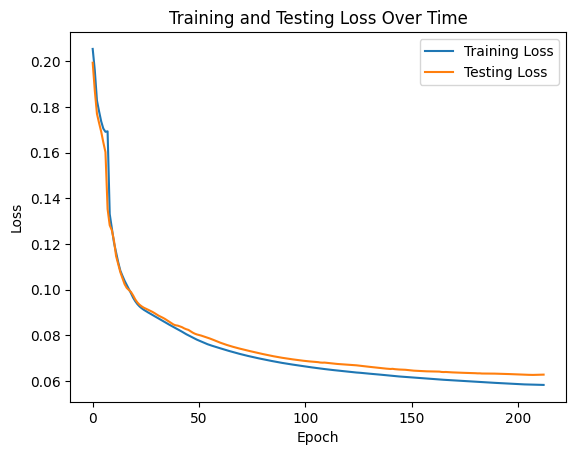

In [79]:
# Set the input sequence length to one week (168 hours)
input_seq_len = 24*3
output = 1
# Initialize the encoder and decoder
model = Model(input_size=1, output_size=output, hidden_dim=128, n_layers=3)

# Set the number of training epochs and learning rate
num_epochs = 1000
learning_rate = 0.0001

# Get the data loaders
file_path = "data/bilan-electrique.csv"
train_loader, test_loader, scaler = preprocess_data(file_path, sequence_length=input_seq_len, output_seq_len=output, batch_size=32)

# Train the model
model = train_model(model, train_loader, test_loader, num_epochs, learning_rate)

# Show the prediction of our model

In [92]:
def forecast(model, df, sequence_length, output_seq_len, scaler, to_predict = 48*7):
    # Extract the last week data and scale it
    last_week = df['consommation_hta'].values[-(sequence_length+to_predict):].reshape(-1, 1)
    last_week_scaled = scaler.transform(last_week)
    print(last_week.shape)
    model.eval()  # set the model to evaluation mode
    predicted = []  # list to store the predicted values
    real = []  # list to store the real values
    first_seq = last_week_scaled[:-to_predict]
    sequence = first_seq
    with torch.no_grad():
        # Start predicting the next week consumption hour by hour
        for i in range(to_predict):  # 24 hours * 7 days = 168 hours
            sequence = torch.FloatTensor(sequence)  # get the last sequence_length values
            sequence = sequence.unsqueeze(0)  # add a batch dimension
            prediction, _ = model(sequence)  # make a prediction
            predicted_value = prediction[0, -1, :].item()  # get the last value (last hour prediction)
            predicted.append(scaler.inverse_transform([[predicted_value]]))  # reverse the scaling and append the prediction to the list
            
            # Append the real value to the list
            try:
                real_value = df['consommation_hta'].values[i-(to_predict)]
                real.append(real_value)
            except IndexError:  # if we've stepped out of the dataset boundaries (means we're predicting the future values)
                real.append(None)
            
            # replace in sequence the first value with the predicted value
            sequence = sequence.squeeze(0)
            sequence = sequence[1:]
            sequence = torch.cat([sequence, torch.FloatTensor([[predicted_value]])], dim=0)
            
    # Flatten the predicted list to have 1D list
    predicted = [item[0][0] for item in predicted]
    
    return predicted, real


In [100]:
time_to_predict = 24*7
predicted, real = forecast(model, df, input_seq_len, output, scaler, to_predict = time_to_predict)
print(predicted)

(240, 1)
[10214524351.631338, 9482641549.683994, 8680837489.1139, 7984399568.281232, 7163749435.933423, 6281817245.610859, 5729532626.521186, 5545451982.544601, 5397338673.400854, 5194227598.608059, 4978731679.547855, 4838623759.525456, 4785015491.864549, 4770313167.871594, 4735299798.264811, 4631243350.086106, 4427204912.210397, 4154489020.5673056, 3956600008.3381343, 3969379554.1711855, 4170914915.973867, 4476076142.429097, 4907348849.688692, 5893920879.375543, 9128942547.781038, 10425176206.022287, 10896093375.749187, 10758003197.351152, 10874618331.709406, 11547829488.309315, 12122797112.99953, 12068677218.074068, 11575517215.4174, 11250244846.08094, 10545472489.269203, 10230614317.64896, 10493983886.560152, 11340922813.54691, 12994780063.122225, 12933423959.938005, 11443587598.446753, 9553278900.880775, 9604959441.145847, 9678119665.359388, 8740447014.670605, 7225093359.357339, 6750806842.605545, 7431376275.728585, 7604697590.114449, 7824383965.373528, 7941854698.893668, 800085144

(240, 1)


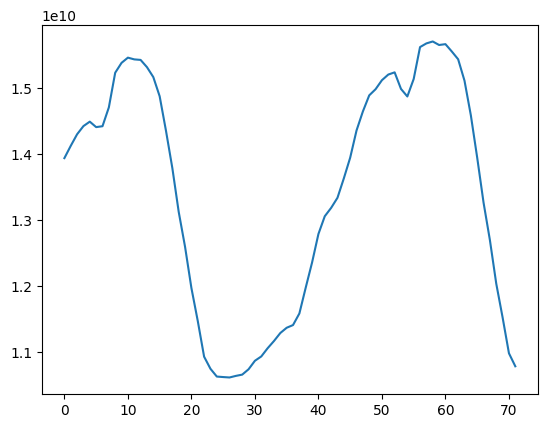

In [103]:
#plot sequence length
last_week = df['consommation_hta'].values[-(input_seq_len+time_to_predict):].reshape(-1, 1)
last_week_scaled = scaler.transform(last_week)
print(last_week.shape)
model.eval()  # set the model to evaluation mode
predicted = []  # list to store the predicted values
real = []  # list to store the real values
first_seq = last_week_scaled[:-time_to_predict]
#unscale
first_seq = scaler.inverse_transform(first_seq)
plt.plot(first_seq)

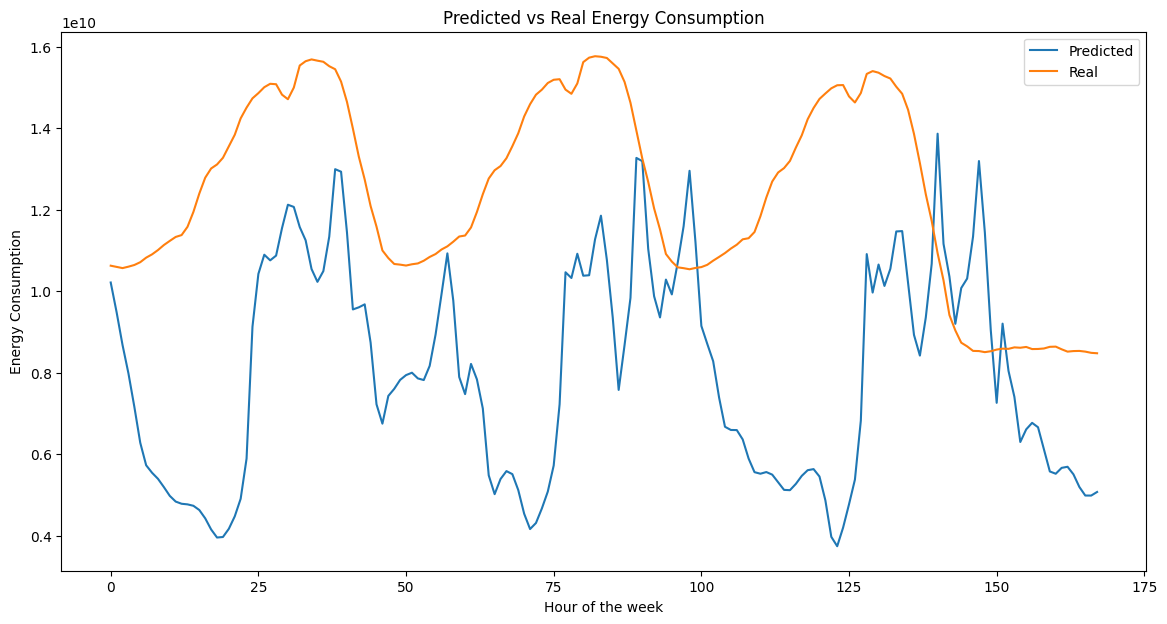

In [101]:
# Create the x axis. It represents the hour of the week from 0 to 168
x = list(range(time_to_predict))

# Plot the predicted and real values
plt.figure(figsize=(14, 7))
plt.plot(x, predicted, label='Predicted')
plt.plot(x, real, label='Real')
plt.title('Predicted vs Real Energy Consumption')
plt.xlabel('Hour of the week')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()
